## Sentiment analysis
-----
### Importing the cleaned data

In [1]:
%store -r game_df_cleaned
%store -r swords_df_cleaned

%store -r game_text_cleaned
%store -r swords_text_cleaned

In [2]:
!pip install afinn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from afinn import Afinn as Afinn
import re
from siuba import *
import pandas as pd
from wordcloud import *

In [4]:
afinn = Afinn()
text_str = ""
for _list in game_text_cleaned:
    for string in _list:
        text_str += string + ' '

game_df_cleaned = pd.DataFrame({
    "word": text_str.split()
})

word_scores = [afinn.score(word) for word in game_df_cleaned['word']]
game_df_cleaned = game_df_cleaned.assign(word_score = word_scores)
game_df_cleaned

,word,word_score
0,GAME,0.0
1,OF,0.0
2,THRONES,0.0
3,Book,0.0
4,Song,0.0
...,...,...
279431,maid,0.0
279432,thirteen,0.0
279433,previous,0.0
279434,Table,0.0


### Function to break first book into chapters
------
#### Chapter 0 ----> PROLOGUE

In [5]:
chapters = ["BRAN", "CATELYN", "DAENERYS", "EDDARD", "JON", "ARYA", "TYRION", "SANSA"]

# CHAPTER 0  -------> PROLOGUE
def select_chapter(dataframe):
    chapter_list = []
    curr_chapter = 0
    flag = False
    for index, row in dataframe.iterrows():
        # This is not hardcoded, in the end of the book the author starts,
        # telling about the different houses and characters backstories and
        # history and this is out of the chapters index
        if re.search("HOUSE", row['word']) or row['word'] == "HOUSE BARATHEON" or flag:
                curr_chapter = curr_chapter
                flag = True
        elif row['word'] in chapters:
            curr_chapter += 1
        chapter_list.append(curr_chapter)
    return chapter_list

### Testing the above function
-----

In [6]:
game_df_cleaned = game_df_cleaned.assign(chapter = select_chapter(game_df_cleaned))
game_df_cleaned


,word,word_score,chapter
0,GAME,0.0,0
1,OF,0.0,0
2,THRONES,0.0,0
3,Book,0.0,0
4,Song,0.0,0
...,...,...,...
279431,maid,0.0,72
279432,thirteen,0.0,72
279433,previous,0.0,72
279434,Table,0.0,72


In [7]:
game_df_cleaned = group_by(game_df_cleaned, 'chapter')
summarized_ss_df = summarize(game_df_cleaned, chapter_score = _.word_score.sum())
summarized_ss_df




,chapter,chapter_score
0,0,-56.0
1,1,-90.0
2,2,2.0
3,3,6.0
4,4,-9.0
...,...,...
68,68,-45.0
69,69,-19.0
70,70,-89.0
71,71,-16.0


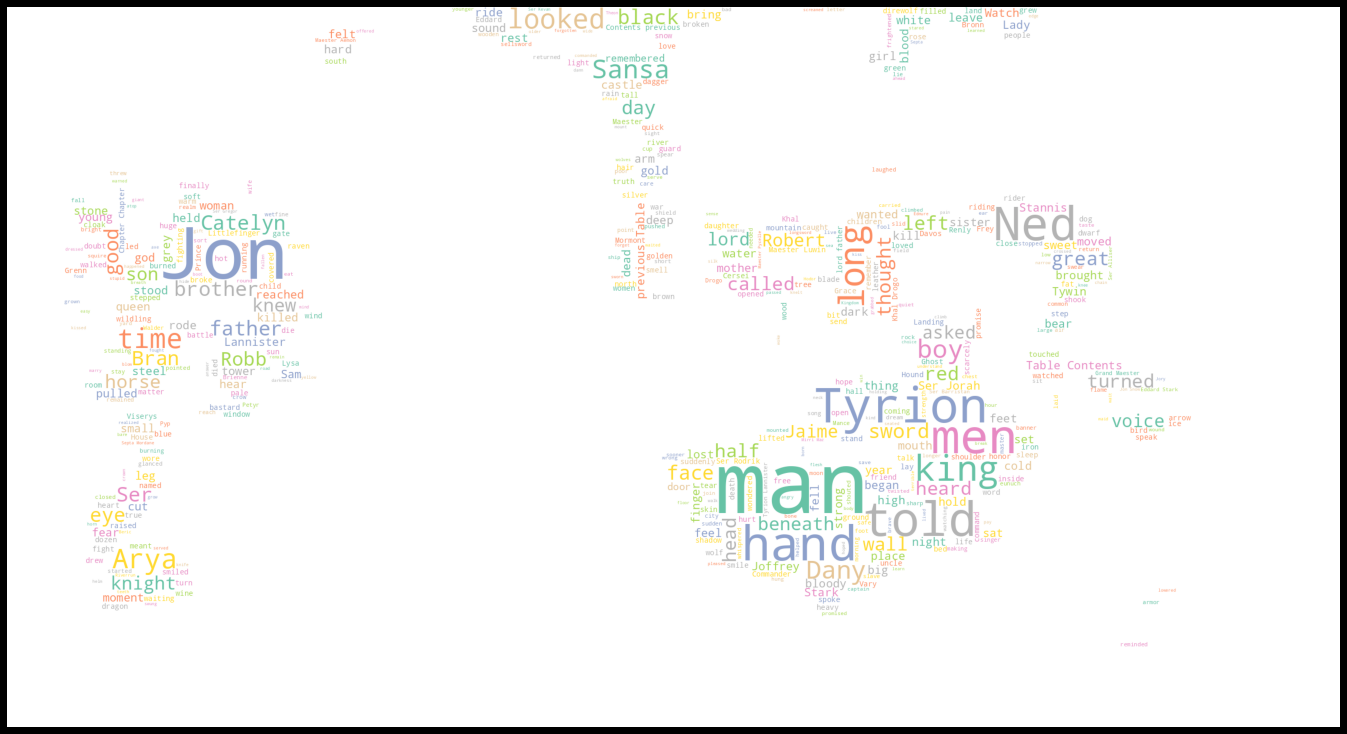

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("map.png"))
mask[mask == 0] = 255



cloudy_cloud_2 = WordCloud(background_color="white", width=800, height=400, colormap='Set2', max_words=500, mask=mask).generate(text_str)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(cloudy_cloud_2)
plt.axis("off")
plt.tight_layout(pad=0)